# single-cell Progeny Production analysis
This notebook provides a central place to integrate and analyze transcriptome and progeny production data.

## Notebook setup
Import python modules:

In [1]:
from IPython.display import display

from dms_variants.constants import CBPALETTE

import numpy

import pandas as pd

import plotnine as p9

import scanpy

import scipy

import statsmodels.stats.multitest

Hardcode input data for this analysis.

In [2]:
matrix = 'results/aligned_fastq10x/scProgenyProduction_trial3/Solo.out/GeneFull/filtered/matrix.mtx'
cell_barcodes = 'results/aligned_fastq10x/scProgenyProduction_trial3/Solo.out/GeneFull/filtered/barcodes.tsv'
features = 'results/aligned_fastq10x/scProgenyProduction_trial3/Solo.out/GeneFull/filtered/features.tsv'
viral_tag_by_cell_csv = 'results/viral_tags_bcs_in_cells/scProgenyProduction_trial3_cell_barcodes_with_viral_tags.csv.gz'
viral_bc_background_freq_csv = 'results/viral_fastq10x/scProgenyProduction_trial3_viral_bc_background_freq.csv.gz'
viral_bc_in_progeny_freq_csv = 'results/viral_progeny/scProgenyProduction_trial3_viral_bc_in_progeny_freq.csv.gz'
expt = 'scProgenyProduction_trial3'
plot = 'results/viral_fastq10x/scProgenyProduction_trial3_viral_bc_correlations.pdf'
viral_genes = ['fluPB2', 'fluPB1', 'fluPA', 'fluHA', 'fluNA', 'fluNP', 'fluM', 'fluNS']
barcoded_viral_genes = ['fluHA', 'fluNA']

Set plotnine theme

In [3]:
p9.theme_set(p9.theme_classic())

## Correlation between transcripts and progeny
This section plots the correlation between viral barcode expression in the transcriptome and viral barcode fraction in the progeny datasets (supernatant or second infection).

### Organize data
First, read the cell barcodes and tags into a pandas dataframe. Only keep relevant columns.

In [4]:
all_cells = pd.read_csv(viral_tag_by_cell_csv)
all_cells = all_cells[['cell_barcode',
                       'infected',
                       'infecting_viral_tag']]
display(all_cells)

,cell_barcode,infected,infecting_viral_tag
0,AAACCCAGTAACAAGT,False,none
1,AAACCCATCATTGCTT,False,none
2,AAACGAAAGATGTTGA,False,none
3,AAACGAAGTACTTCCC,True,both
4,AAACGAAGTAGACGTG,True,wt
...,...,...,...
3363,TTTGATCTCCCGTTCA,False,none
3364,TTTGATCTCGCATTGA,True,wt
3365,TTTGGAGAGTTGCCTA,False,none
3366,TTTGGAGGTATCGTTG,True,wt


Next, read the viral barcode frequencies from the transcriptome.

In [5]:
transcriptome_viral_bc_freqs = pd.read_csv(viral_bc_background_freq_csv)
assert set(transcriptome_viral_bc_freqs['gene']) == set(barcoded_viral_genes), \
       "Barcoded genes in barcode counts do not match expectation."
display(transcriptome_viral_bc_freqs)

,cell_barcode,infected,infecting_viral_tag,frac_viral_UMIs,gene,viral_barcode,viral_bc_UMIs,frac_viral_bc_UMIs,reject_uninfected
0,AAACCCAGTAACAAGT,False,none,0.000048,fluHA,NaN,0,0.000000,False
1,AAACCCATCATTGCTT,False,none,0.000051,fluHA,NaN,0,0.000000,False
2,AAACGAAAGATGTTGA,False,none,0.000204,fluHA,NaN,0,0.000000,False
3,AAACGAAGTACTTCCC,True,both,0.448272,fluHA,NaN,0,0.000000,False
4,AAACGAAGTAGACGTG,True,wt,0.040116,fluHA,AAGTAAGCGACATGAG,93,0.001731,True
...,...,...,...,...,...,...,...,...,...
9185,TTTGATCTCCCGTTCA,False,none,0.000109,fluNA,NaN,0,0.000000,False
9186,TTTGATCTCGCATTGA,True,wt,0.063156,fluNA,NaN,0,0.000000,False
9187,TTTGGAGAGTTGCCTA,False,none,0.000070,fluNA,NaN,0,0.000000,False
9188,TTTGGAGGTATCGTTG,True,wt,0.024534,fluNA,ACATCTTATTTACACG,15,0.000230,True


Read the viral barcode frequencies from the progeny. **For now just work with supernatant data. Remove second_infection frequencies.**

In [6]:
progeny_viral_bc_freqs = pd.read_csv(viral_bc_in_progeny_freq_csv)
assert set(progeny_viral_bc_freqs['gene']) == set(barcoded_viral_genes), \
       "Barcoded genes in barcode counts do not match expectation."
progeny_viral_bc_freqs = (progeny_viral_bc_freqs
                          .rename(columns={'barcode': 'viral_barcode',
                                           'tag': 'infecting_viral_tag',
                                           'mean_freq': 'freq_progeny',
                                           'mean_count': 'sup_count'}))
progeny_viral_bc_freqs = (progeny_viral_bc_freqs
                          .query('source == "supernatant"'))
progeny_viral_bc_freqs = progeny_viral_bc_freqs.drop(columns = 'source')
display(progeny_viral_bc_freqs)

,infecting_viral_tag,gene,viral_barcode,sup_count,freq_progeny
0,syn,fluHA,AAAAAAGCACGAGCAG,0.5,2.507618e-07
1,syn,fluHA,AAAAAATCCTTCAGCA,0.5,2.574453e-07
2,syn,fluHA,AAAAAATGGCGACGCT,0.5,2.574453e-07
3,syn,fluHA,AAAAAATTGGTTTACT,0.5,2.574453e-07
4,syn,fluHA,AAAAACACTCACAAGT,0.5,2.574453e-07
...,...,...,...,...,...
57485,wt,fluNA,TTTTTCCCTTACATAT,1.0,4.799773e-07
57486,wt,fluNA,TTTTTCTTACGATCAC,1.0,4.799773e-07
57487,wt,fluNA,TTTTTCTTCGAGATAG,10.0,4.799773e-06
57488,wt,fluNA,TTTTTGGGATCATTGC,2.0,9.599545e-07


Merge dataframes to one. This will be done in two steps. First, merge transcriptome frequencies with all cells tag info.  Then, merge supernatant frequencies into this dataframe.

Structure of the final dataframe should be as follows:
1. Cell barcode
2. Infected
3. Infecting viral tag
4. Gene
5. Viral barcode
6. Frequency in transcriptome (`frac_viral_bc_UMIs`)
7. Frequency in supernatant sequencing (`freq_progeny`)

In [7]:
viral_bc_freqs = pd.merge(
    left=pd.concat([all_cells.assign(gene=gene)
                    for gene in barcoded_viral_genes]),
    right=transcriptome_viral_bc_freqs,
    how='outer',
    on=['cell_barcode', 'gene', 'infected', 'infecting_viral_tag'],
    validate='one_to_many')

assert (viral_bc_freqs['cell_barcode'].unique() ==
        all_cells['cell_barcode'].unique()).all(), \
       "Cell barcodes in merged dataframe don't " \
       "match barcodes in source data."
assert (viral_bc_freqs['viral_barcode'].nunique() ==
        transcriptome_viral_bc_freqs['viral_barcode'].nunique()), \
       "Number of viral barcodes in merged dataframe doesn't " \
       "match number of barcodes in source data."

viral_bc_freqs = pd.merge(
    left=viral_bc_freqs,
    right=progeny_viral_bc_freqs,
    how='outer',
    on=['viral_barcode', 'gene', 'infecting_viral_tag'])
# Need to think of what asserts to include here

display(viral_bc_freqs)

,cell_barcode,infected,infecting_viral_tag,gene,frac_viral_UMIs,viral_barcode,viral_bc_UMIs,frac_viral_bc_UMIs,reject_uninfected,sup_count,freq_progeny
0,AAACCCAGTAACAAGT,False,none,fluHA,0.000048,NaN,0.0,0.0,False,NaN,NaN
1,AAACCCATCATTGCTT,False,none,fluHA,0.000051,NaN,0.0,0.0,False,NaN,NaN
2,AAACGAAAGATGTTGA,False,none,fluHA,0.000204,NaN,0.0,0.0,False,NaN,NaN
3,AAACGCTCAAATGATG,False,none,fluHA,0.000107,NaN,0.0,0.0,False,NaN,NaN
4,AAACGCTCATGGACAG,False,none,fluHA,0.000119,NaN,0.0,0.0,False,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
66332,NaN,NaN,wt,fluNA,NaN,TTTTTCCCTTACATAT,NaN,NaN,NaN,1.0,4.799773e-07
66333,NaN,NaN,wt,fluNA,NaN,TTTTTCTTACGATCAC,NaN,NaN,NaN,1.0,4.799773e-07
66334,NaN,NaN,wt,fluNA,NaN,TTTTTCTTCGAGATAG,NaN,NaN,NaN,10.0,4.799773e-06
66335,NaN,NaN,wt,fluNA,NaN,TTTTTGGGATCATTGC,NaN,NaN,NaN,2.0,9.599545e-07


Set viral barcode freqs missing in progeny data to 0. If a viral barcode is seen in the cell but not in the progeny data, this is meaningful.

In [8]:
viral_bc_freqs['freq_progeny'] = viral_bc_freqs['freq_progeny'].fillna(0)

viral_bc_freqs

,cell_barcode,infected,infecting_viral_tag,gene,frac_viral_UMIs,viral_barcode,viral_bc_UMIs,frac_viral_bc_UMIs,reject_uninfected,sup_count,freq_progeny
0,AAACCCAGTAACAAGT,False,none,fluHA,0.000048,NaN,0.0,0.0,False,NaN,0.000000e+00
1,AAACCCATCATTGCTT,False,none,fluHA,0.000051,NaN,0.0,0.0,False,NaN,0.000000e+00
2,AAACGAAAGATGTTGA,False,none,fluHA,0.000204,NaN,0.0,0.0,False,NaN,0.000000e+00
3,AAACGCTCAAATGATG,False,none,fluHA,0.000107,NaN,0.0,0.0,False,NaN,0.000000e+00
4,AAACGCTCATGGACAG,False,none,fluHA,0.000119,NaN,0.0,0.0,False,NaN,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...
66332,NaN,NaN,wt,fluNA,NaN,TTTTTCCCTTACATAT,NaN,NaN,NaN,1.0,4.799773e-07
66333,NaN,NaN,wt,fluNA,NaN,TTTTTCTTACGATCAC,NaN,NaN,NaN,1.0,4.799773e-07
66334,NaN,NaN,wt,fluNA,NaN,TTTTTCTTCGAGATAG,NaN,NaN,NaN,10.0,4.799773e-06
66335,NaN,NaN,wt,fluNA,NaN,TTTTTGGGATCATTGC,NaN,NaN,NaN,2.0,9.599545e-07


## Annotated raw plots
**I am not doing any filtering on this data yet. I will plot the data in its raw form first.**

### Plots

#### Viral transcription
***Note:*** `NA` values (0 counts) in the transcriptome data are plotted on the far left side of this graph at `1e-8`.

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/plotnine/layer.py:372: PlotnineWarning: stat_bin : Removed 4851 rows containing non-finite values.
/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/plotnine/guides/guides.py:197: PlotnineWarning: Cannot generate legend for the 'fill' aesthetic. Make sure you have mapped a variable to it


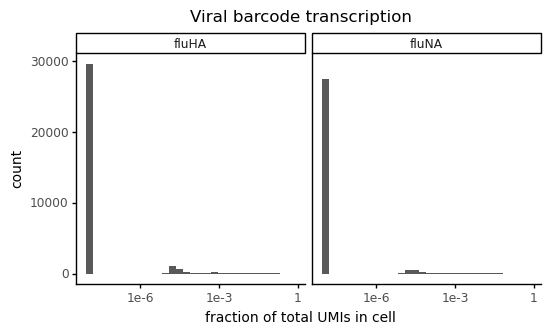

<ggplot: (8745996050710)>

In [9]:
fig = (p9.ggplot(viral_bc_freqs.fillna(1e-8),
                 p9.aes(x='frac_viral_bc_UMIs')) +
       p9.geom_histogram(bins=30) +
       p9.facet_grid('~gene') +
       p9.ggtitle(f'Viral barcode transcription') +
       p9.scale_x_log10() +
       p9.labs(x='fraction of total UMIs in cell') +
       p9.theme(figure_size=(6, 3),
                plot_title=p9.element_text(size=12),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=10),
                legend_title_align='center') +
       p9.scale_fill_manual(CBPALETTE[0:]))
display(fig)

Without the `NA` values:

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/plotnine/layer.py:372: PlotnineWarning: stat_bin : Removed 4851 rows containing non-finite values.
/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/plotnine/guides/guides.py:197: PlotnineWarning: Cannot generate legend for the 'fill' aesthetic. Make sure you have mapped a variable to it


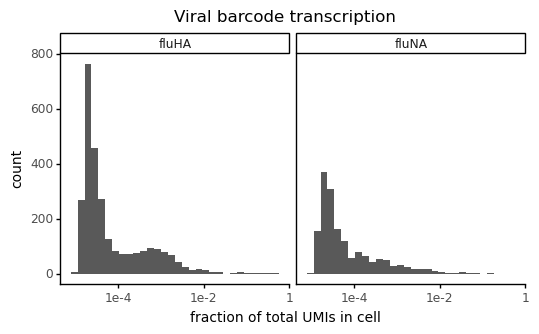

<ggplot: (8746651972756)>

In [10]:
fig = (p9.ggplot(viral_bc_freqs.query('frac_viral_bc_UMIs.notnull()', engine='python'),
                 p9.aes(x='frac_viral_bc_UMIs')) +
       p9.geom_histogram(bins=30) +
       p9.facet_grid('~gene') +
       p9.ggtitle(f'Viral barcode transcription') +
       p9.scale_x_log10() +
       p9.labs(x='fraction of total UMIs in cell') +
       p9.theme(figure_size=(6, 3),
                plot_title=p9.element_text(size=12),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=10),
                legend_title_align='center') +
       p9.scale_fill_manual(CBPALETTE[0:]))
display(fig)

#### Supernatant progeny production
***Note:*** `NA` values (0 counts) in the supernatant data are plotted on the far left side of this graph at `1e-8`.

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/plotnine/layer.py:372: PlotnineWarning: stat_bin : Removed 8755 rows containing non-finite values.


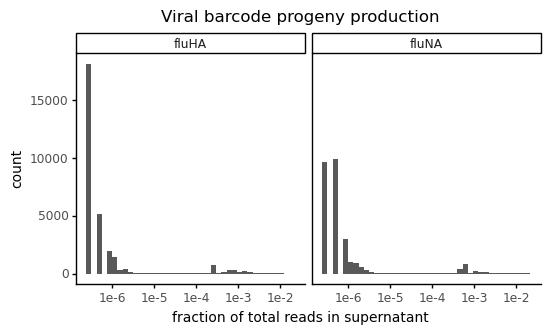

<ggplot: (8746651719283)>

In [11]:
fig = (p9.ggplot(viral_bc_freqs.fillna(1e-8),
                 p9.aes(x='freq_progeny')) +
       p9.geom_histogram(bins=40) +
       p9.facet_grid('~gene') +
       p9.ggtitle(f'Viral barcode progeny production') +
       p9.labs(x='fraction of total reads in supernatant') +
       p9.theme(figure_size=(6, 3),
                plot_title=p9.element_text(size=12),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=10),
                legend_title_align='center') +
       p9.scale_x_log10())
display(fig)

Without the 0 values:

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/plotnine/layer.py:372: PlotnineWarning: stat_bin : Removed 8755 rows containing non-finite values.


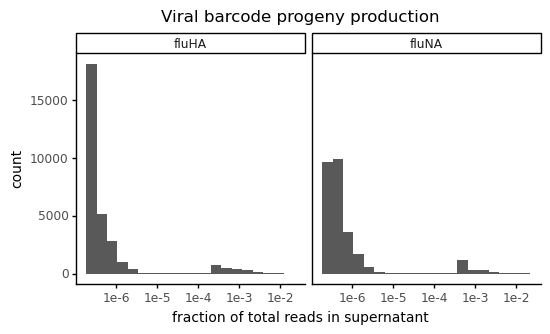

<ggplot: (8746651611504)>

In [12]:
fig = (p9.ggplot(viral_bc_freqs.query('freq_progeny.notnull()', engine='python'),
                 p9.aes(x='freq_progeny')) +
       p9.geom_histogram(bins=20) +
       p9.facet_grid('~gene') +
       p9.ggtitle(f'Viral barcode progeny production') +
       p9.labs(x='fraction of total reads in supernatant') +
       p9.theme(figure_size=(6, 3),
                plot_title=p9.element_text(size=12),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=10),
                legend_title_align='center') +
       p9.scale_x_log10())
display(fig)

#### Correlation of viral transcription and progeny production

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/plotnine/layer.py:467: PlotnineWarning: geom_point : Removed 57147 rows containing missing values.


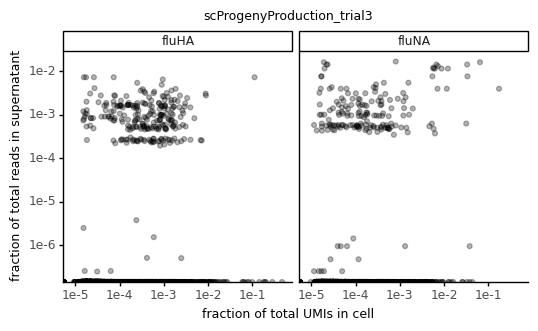

<ggplot: (8746651219631)>

In [13]:
fig = (p9.ggplot(viral_bc_freqs,
                 p9.aes(x='frac_viral_bc_UMIs',
                        y='freq_progeny')) +
       p9.geom_point(alpha=0.3) +
       p9.facet_grid('~gene') +
       p9.ggtitle(f'{expt}') +
       p9.scale_x_log10() +
       p9.scale_y_log10() +
       p9.labs(x='fraction of total UMIs in cell',
               y='fraction of total reads in supernatant') +
       p9.theme(figure_size=(6, 3),
                plot_title=p9.element_text(size=9),
                axis_title=p9.element_text(size=9),
                legend_title=p9.element_text(size=9),
                legend_title_align='center'))
display(fig)

Export correlation plot:

In [14]:
print(f"Saving correlation plot to {plot}")
p9.ggsave(plot=fig, filename=plot, verbose=False)

Saving correlation plot to results/viral_fastq10x/scProgenyProduction_trial3_viral_bc_correlations.pdf


/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/plotnine/layer.py:467: PlotnineWarning: geom_point : Removed 57147 rows containing missing values.


## Annotating plot

### Infected

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10


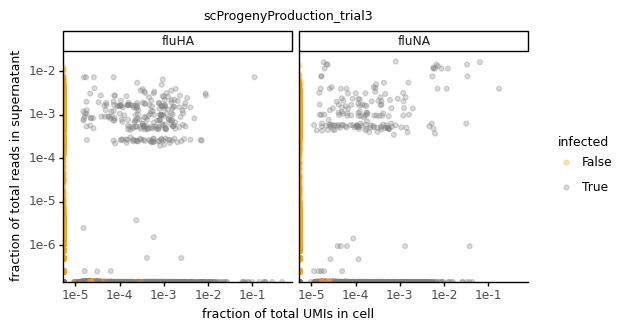

<ggplot: (8746651730535)>

In [15]:
fig = (p9.ggplot(viral_bc_freqs.fillna(0),
                 p9.aes(x='frac_viral_bc_UMIs',
                        y='freq_progeny',
                        color='infected')) +
       p9.geom_point(alpha=0.3) +
       p9.facet_grid('~gene') +
       p9.ggtitle(f'{expt}') +
       p9.scale_x_log10() +
       p9.scale_y_log10() +
       p9.labs(x='fraction of total UMIs in cell',
               y='fraction of total reads in supernatant') +
       p9.theme(figure_size=(6, 3),
                plot_title=p9.element_text(size=9),
                axis_title=p9.element_text(size=9),
                legend_title=p9.element_text(size=9),
                legend_title_align='center') +
       p9.scale_color_manual(values=['orange','grey']))
display(fig)

### Variant

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10


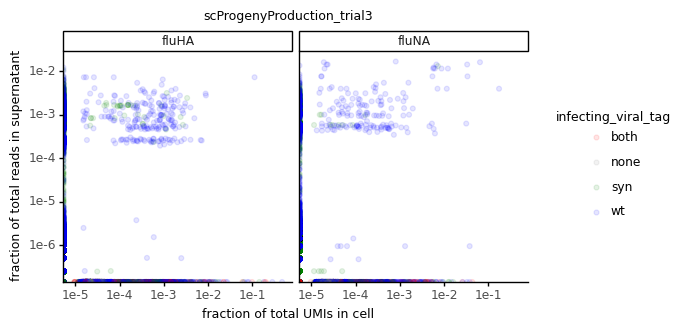

<ggplot: (8746281506973)>

In [16]:
fig = (p9.ggplot(viral_bc_freqs.fillna(0),
                 p9.aes(x='frac_viral_bc_UMIs',
                        y='freq_progeny',
                        color='infecting_viral_tag')) +
       p9.geom_point(alpha=0.1) +
       p9.facet_grid('~gene') +
       p9.ggtitle(f'{expt}') +
       p9.scale_x_log10() +
       p9.scale_y_log10() +
       p9.labs(x='fraction of total UMIs in cell',
               y='fraction of total reads in supernatant') +
       p9.theme(figure_size=(6, 3),
                plot_title=p9.element_text(size=9),
                axis_title=p9.element_text(size=9),
                legend_title=p9.element_text(size=9),
                legend_title_align='center') +
       p9.scale_color_manual(values=['red','grey','green','blue']))
display(fig)

### Above background frequency

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10


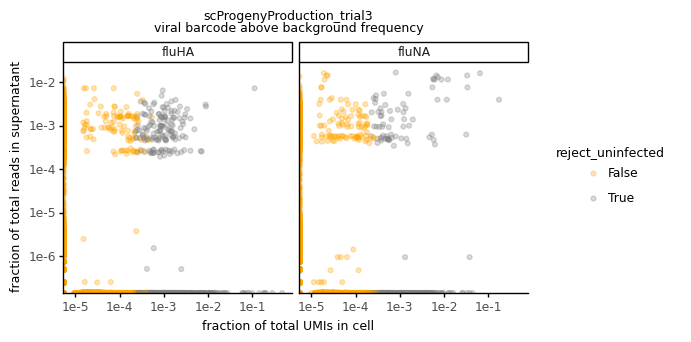

<ggplot: (8746651612814)>

In [17]:
fig = (p9.ggplot(viral_bc_freqs.fillna(0),
                 p9.aes(x='frac_viral_bc_UMIs',
                        y='freq_progeny',
                        color='reject_uninfected')) +
       p9.geom_point(alpha=0.3) +
       p9.facet_grid('~gene') +
       p9.ggtitle(f'{expt}\n'
                  'viral barcode above background frequency') +
       p9.scale_x_log10() +
       p9.scale_y_log10() +
       p9.labs(x='fraction of total UMIs in cell',
               y='fraction of total reads in supernatant') +
       p9.theme(figure_size=(6, 3),
                plot_title=p9.element_text(size=9),
                axis_title=p9.element_text(size=9),
                legend_title=p9.element_text(size=9),
                legend_title_align='center') +
       p9.scale_color_manual(values=['orange','grey']))
display(fig)

### Viral barcode is found in at least one infected cell
I will label each viral barcode by whether it is found above background frequency in at least one cell labelled as infected.

In [18]:
in_infected_cell = (pd.DataFrame(viral_bc_freqs
                                .query('reject_uninfected == True '
                                       'and infected == True')
                                ['viral_barcode']
                                .unique())
                    .rename(columns={0:'viral_barcode'}))
in_infected_cell['in_infected_cell'] = True

viral_bc_freqs = pd.merge(
                    left=viral_bc_freqs,
                    right=in_infected_cell,
                    on=['viral_barcode'],
                    how='left')

viral_bc_freqs['in_infected_cell'] = viral_bc_freqs['in_infected_cell'].fillna(False)
viral_bc_freqs

,cell_barcode,infected,infecting_viral_tag,gene,frac_viral_UMIs,viral_barcode,viral_bc_UMIs,frac_viral_bc_UMIs,reject_uninfected,sup_count,freq_progeny,in_infected_cell
0,AAACCCAGTAACAAGT,False,none,fluHA,0.000048,NaN,0.0,0.0,False,NaN,0.000000e+00,False
1,AAACCCATCATTGCTT,False,none,fluHA,0.000051,NaN,0.0,0.0,False,NaN,0.000000e+00,False
2,AAACGAAAGATGTTGA,False,none,fluHA,0.000204,NaN,0.0,0.0,False,NaN,0.000000e+00,False
3,AAACGCTCAAATGATG,False,none,fluHA,0.000107,NaN,0.0,0.0,False,NaN,0.000000e+00,False
4,AAACGCTCATGGACAG,False,none,fluHA,0.000119,NaN,0.0,0.0,False,NaN,0.000000e+00,False
...,...,...,...,...,...,...,...,...,...,...,...,...
66332,NaN,NaN,wt,fluNA,NaN,TTTTTCCCTTACATAT,NaN,NaN,NaN,1.0,4.799773e-07,False
66333,NaN,NaN,wt,fluNA,NaN,TTTTTCTTACGATCAC,NaN,NaN,NaN,1.0,4.799773e-07,False
66334,NaN,NaN,wt,fluNA,NaN,TTTTTCTTCGAGATAG,NaN,NaN,NaN,10.0,4.799773e-06,False
66335,NaN,NaN,wt,fluNA,NaN,TTTTTGGGATCATTGC,NaN,NaN,NaN,2.0,9.599545e-07,False


/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10


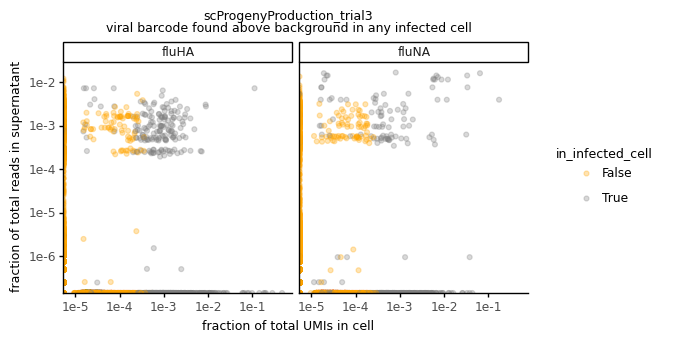

<ggplot: (8746651777946)>

In [19]:
fig = (p9.ggplot(viral_bc_freqs.fillna(0),
                 p9.aes(x='frac_viral_bc_UMIs',
                        y='freq_progeny',
                        color='in_infected_cell')) +
       p9.geom_point(alpha=0.3) +
       p9.facet_grid('~gene') +
       p9.ggtitle(f'{expt}\n'
                  'viral barcode found above background in any infected cell') +
       p9.scale_x_log10() +
       p9.scale_y_log10() +
       p9.labs(x='fraction of total UMIs in cell',
               y='fraction of total reads in supernatant') +
       p9.theme(figure_size=(6, 3),
                plot_title=p9.element_text(size=9),
                axis_title=p9.element_text(size=9),
                legend_title=p9.element_text(size=9),
                legend_title_align='center') +
       p9.scale_color_manual(values=['orange','grey']))
display(fig)

### Cells per viral barcode
I want to annotate viral barcodes that are found above background in multiple cells. This should be very unlikely in a low MOI infection.

Calculate the number of cells each viral barcode is found in:

In [20]:
n_cell_bc = (viral_bc_freqs
             .query('(reject_uninfected == True) and '
                    '(cell_barcode.notna())',
                    engine='python')
             .groupby(['infecting_viral_tag',
                       'gene',
                       'viral_barcode',
                       'reject_uninfected'])
             ['cell_barcode']
             .nunique()
             .reset_index()
             .rename(columns={'cell_barcode': 'n_cell_bc'}))

n_cell_bc

viral_bc_freqs = pd.merge(
    viral_bc_freqs,
    n_cell_bc,
    on=['infecting_viral_tag',
        'gene',
        'viral_barcode',
        'reject_uninfected'],
    how='left')

viral_bc_freqs

,cell_barcode,infected,infecting_viral_tag,gene,frac_viral_UMIs,viral_barcode,viral_bc_UMIs,frac_viral_bc_UMIs,reject_uninfected,sup_count,freq_progeny,in_infected_cell,n_cell_bc
0,AAACCCAGTAACAAGT,False,none,fluHA,0.000048,NaN,0.0,0.0,False,NaN,0.000000e+00,False,NaN
1,AAACCCATCATTGCTT,False,none,fluHA,0.000051,NaN,0.0,0.0,False,NaN,0.000000e+00,False,NaN
2,AAACGAAAGATGTTGA,False,none,fluHA,0.000204,NaN,0.0,0.0,False,NaN,0.000000e+00,False,NaN
3,AAACGCTCAAATGATG,False,none,fluHA,0.000107,NaN,0.0,0.0,False,NaN,0.000000e+00,False,NaN
4,AAACGCTCATGGACAG,False,none,fluHA,0.000119,NaN,0.0,0.0,False,NaN,0.000000e+00,False,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
66332,NaN,NaN,wt,fluNA,NaN,TTTTTCCCTTACATAT,NaN,NaN,NaN,1.0,4.799773e-07,False,NaN
66333,NaN,NaN,wt,fluNA,NaN,TTTTTCTTACGATCAC,NaN,NaN,NaN,1.0,4.799773e-07,False,NaN
66334,NaN,NaN,wt,fluNA,NaN,TTTTTCTTCGAGATAG,NaN,NaN,NaN,10.0,4.799773e-06,False,NaN
66335,NaN,NaN,wt,fluNA,NaN,TTTTTGGGATCATTGC,NaN,NaN,NaN,2.0,9.599545e-07,False,NaN


Plot distribution of cell barcode per viral barcode. Only look at viral barcodes found above background and present in the transcriptome.

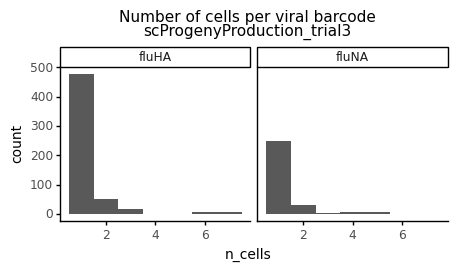

<ggplot: (8745969731416)>

In [21]:
fig = (p9.ggplot(viral_bc_freqs
                 .query('(reject_uninfected == True) and '
                        '(cell_barcode.notna())',
                        engine='python')) +
       p9.geom_histogram(p9.aes(x='n_cell_bc'),
                         binwidth=1,
                         position='dodge') +
       p9.facet_grid('~gene') +
       p9.ggtitle('Number of cells per viral barcode\n'
                  f'{expt}') +
       p9.xlab('n_cells') +
       p9.theme(figure_size=(5, 2),
                plot_title=p9.element_text(size=11),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=10),
                legend_title_align='center'))
display(fig)

Now I will label viral barcodes that are found in more than 1 cells.

In [22]:
viral_bc_freqs['gt1_cell'] = (
    viral_bc_freqs['n_cell_bc'] > 1)

viral_bc_freqs

,cell_barcode,infected,infecting_viral_tag,gene,frac_viral_UMIs,viral_barcode,viral_bc_UMIs,frac_viral_bc_UMIs,reject_uninfected,sup_count,freq_progeny,in_infected_cell,n_cell_bc,gt1_cell
0,AAACCCAGTAACAAGT,False,none,fluHA,0.000048,NaN,0.0,0.0,False,NaN,0.000000e+00,False,NaN,False
1,AAACCCATCATTGCTT,False,none,fluHA,0.000051,NaN,0.0,0.0,False,NaN,0.000000e+00,False,NaN,False
2,AAACGAAAGATGTTGA,False,none,fluHA,0.000204,NaN,0.0,0.0,False,NaN,0.000000e+00,False,NaN,False
3,AAACGCTCAAATGATG,False,none,fluHA,0.000107,NaN,0.0,0.0,False,NaN,0.000000e+00,False,NaN,False
4,AAACGCTCATGGACAG,False,none,fluHA,0.000119,NaN,0.0,0.0,False,NaN,0.000000e+00,False,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66332,NaN,NaN,wt,fluNA,NaN,TTTTTCCCTTACATAT,NaN,NaN,NaN,1.0,4.799773e-07,False,NaN,False
66333,NaN,NaN,wt,fluNA,NaN,TTTTTCTTACGATCAC,NaN,NaN,NaN,1.0,4.799773e-07,False,NaN,False
66334,NaN,NaN,wt,fluNA,NaN,TTTTTCTTCGAGATAG,NaN,NaN,NaN,10.0,4.799773e-06,False,NaN,False
66335,NaN,NaN,wt,fluNA,NaN,TTTTTGGGATCATTGC,NaN,NaN,NaN,2.0,9.599545e-07,False,NaN,False


Plot number of viral barcodes that were found in more than 1 cell:

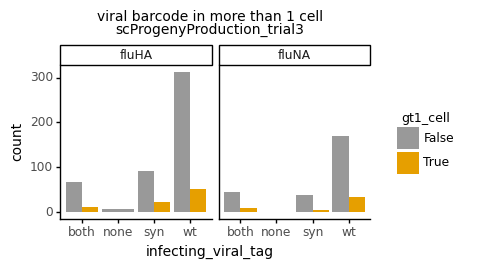

<ggplot: (8746651753238)>

In [23]:
output_fig = (p9.ggplot((viral_bc_freqs
                         .query('(reject_uninfected == True) and '
                                '(cell_barcode.notna())',
                                engine='python')),
                        p9.aes(x='infecting_viral_tag',
                               fill='gt1_cell')) +
              p9.geom_bar(stat='count', position='dodge') +
              p9.ggtitle('viral barcode in more than 1 cell\n'
                         f'{expt}') +
              p9.facet_grid('~gene') +
              p9.theme(figure_size=(4, 2),
                       plot_title=p9.element_text(size=10),
                       axis_title=p9.element_text(size=10),
                       legend_title=p9.element_text(size=9),
                       legend_title_align='center') +
              p9.scale_fill_manual(CBPALETTE[0:]))
display(output_fig)

Plot transcript-supernatant correlation with this info annotated:

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10


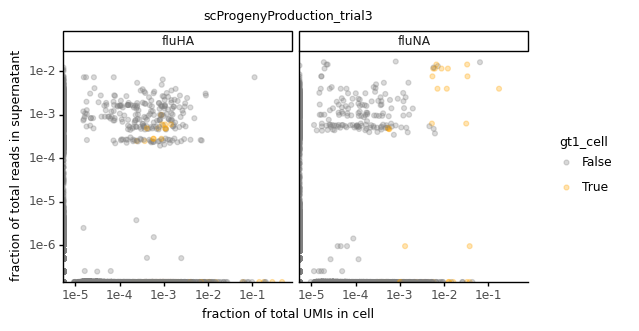

<ggplot: (8745969071583)>

In [24]:
fig = (p9.ggplot(viral_bc_freqs.fillna(0),
                 p9.aes(x='frac_viral_bc_UMIs',
                        y='freq_progeny',
                        color='gt1_cell')) +
       p9.geom_point(alpha=0.3) +
       p9.facet_grid('~gene') +
       p9.ggtitle(f'{expt}') +
       p9.scale_x_log10() +
       p9.scale_y_log10() +
       p9.labs(x='fraction of total UMIs in cell',
               y='fraction of total reads in supernatant') +
       p9.theme(figure_size=(6, 3),
                plot_title=p9.element_text(size=9),
                axis_title=p9.element_text(size=9),
                legend_title=p9.element_text(size=9),
                legend_title_align='center') +
       p9.scale_color_manual(values=['grey','orange']))
display(fig)

### Viral barcodes per cell
I want to annotate cells with the number of viral barcodes above background on each segment.

Calculate the number of viral barcodes each segment has per cell:

In [25]:
n_viral_bc = (viral_bc_freqs
             .query('(reject_uninfected == True) and '
                    '(cell_barcode.notna())',
                    engine='python')
             .groupby(['infecting_viral_tag',
                       'gene',
                       'cell_barcode',
                       'reject_uninfected'])
             ['viral_barcode']
             .nunique()
             .reset_index()
             .rename(columns={'viral_barcode': 'n_viral_bc'}))

viral_bc_freqs = pd.merge(
    viral_bc_freqs,
    n_viral_bc,
    on=['infecting_viral_tag',
        'gene',
        'cell_barcode',
        'reject_uninfected'],
    how='left')

viral_bc_freqs

,cell_barcode,infected,infecting_viral_tag,gene,frac_viral_UMIs,viral_barcode,viral_bc_UMIs,frac_viral_bc_UMIs,reject_uninfected,sup_count,freq_progeny,in_infected_cell,n_cell_bc,gt1_cell,n_viral_bc
0,AAACCCAGTAACAAGT,False,none,fluHA,0.000048,NaN,0.0,0.0,False,NaN,0.000000e+00,False,NaN,False,NaN
1,AAACCCATCATTGCTT,False,none,fluHA,0.000051,NaN,0.0,0.0,False,NaN,0.000000e+00,False,NaN,False,NaN
2,AAACGAAAGATGTTGA,False,none,fluHA,0.000204,NaN,0.0,0.0,False,NaN,0.000000e+00,False,NaN,False,NaN
3,AAACGCTCAAATGATG,False,none,fluHA,0.000107,NaN,0.0,0.0,False,NaN,0.000000e+00,False,NaN,False,NaN
4,AAACGCTCATGGACAG,False,none,fluHA,0.000119,NaN,0.0,0.0,False,NaN,0.000000e+00,False,NaN,False,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66332,NaN,NaN,wt,fluNA,NaN,TTTTTCCCTTACATAT,NaN,NaN,NaN,1.0,4.799773e-07,False,NaN,False,NaN
66333,NaN,NaN,wt,fluNA,NaN,TTTTTCTTACGATCAC,NaN,NaN,NaN,1.0,4.799773e-07,False,NaN,False,NaN
66334,NaN,NaN,wt,fluNA,NaN,TTTTTCTTCGAGATAG,NaN,NaN,NaN,10.0,4.799773e-06,False,NaN,False,NaN
66335,NaN,NaN,wt,fluNA,NaN,TTTTTGGGATCATTGC,NaN,NaN,NaN,2.0,9.599545e-07,False,NaN,False,NaN


Plot distribution of viral barcode per cell. Only look at viral barcodes found above background and present in the transcriptome.

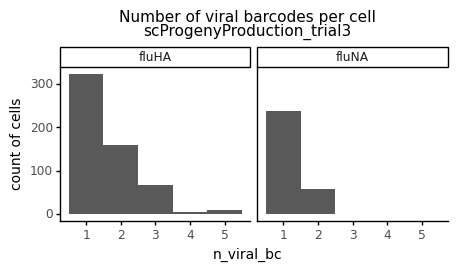

<ggplot: (8745968698245)>

In [26]:
fig = (p9.ggplot(viral_bc_freqs
                 .query('(reject_uninfected == True) and '
                        '(cell_barcode.notna())',
                        engine='python')) +
       p9.geom_histogram(p9.aes(x='n_viral_bc'),
                         binwidth=1,
                         position='dodge') +
       p9.facet_grid('~gene') +
       p9.ggtitle('Number of viral barcodes per cell\n'
                  f'{expt}') +
       p9.xlab('n_viral_bc') +
       p9.ylab('count of cells') +
       p9.theme(figure_size=(5, 2),
                plot_title=p9.element_text(size=11),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=10),
                legend_title_align='center'))
display(fig)

Now I will label cells that have more than 1 viral barcode on a segment.

In [27]:
viral_bc_freqs['gt1_viral_bc'] = (
    viral_bc_freqs['n_viral_bc'] > 1)

viral_bc_freqs

,cell_barcode,infected,infecting_viral_tag,gene,frac_viral_UMIs,viral_barcode,viral_bc_UMIs,frac_viral_bc_UMIs,reject_uninfected,sup_count,freq_progeny,in_infected_cell,n_cell_bc,gt1_cell,n_viral_bc,gt1_viral_bc
0,AAACCCAGTAACAAGT,False,none,fluHA,0.000048,NaN,0.0,0.0,False,NaN,0.000000e+00,False,NaN,False,NaN,False
1,AAACCCATCATTGCTT,False,none,fluHA,0.000051,NaN,0.0,0.0,False,NaN,0.000000e+00,False,NaN,False,NaN,False
2,AAACGAAAGATGTTGA,False,none,fluHA,0.000204,NaN,0.0,0.0,False,NaN,0.000000e+00,False,NaN,False,NaN,False
3,AAACGCTCAAATGATG,False,none,fluHA,0.000107,NaN,0.0,0.0,False,NaN,0.000000e+00,False,NaN,False,NaN,False
4,AAACGCTCATGGACAG,False,none,fluHA,0.000119,NaN,0.0,0.0,False,NaN,0.000000e+00,False,NaN,False,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66332,NaN,NaN,wt,fluNA,NaN,TTTTTCCCTTACATAT,NaN,NaN,NaN,1.0,4.799773e-07,False,NaN,False,NaN,False
66333,NaN,NaN,wt,fluNA,NaN,TTTTTCTTACGATCAC,NaN,NaN,NaN,1.0,4.799773e-07,False,NaN,False,NaN,False
66334,NaN,NaN,wt,fluNA,NaN,TTTTTCTTCGAGATAG,NaN,NaN,NaN,10.0,4.799773e-06,False,NaN,False,NaN,False
66335,NaN,NaN,wt,fluNA,NaN,TTTTTGGGATCATTGC,NaN,NaN,NaN,2.0,9.599545e-07,False,NaN,False,NaN,False


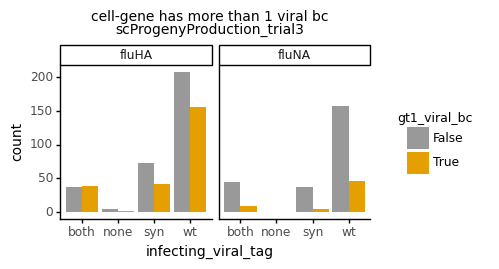

<ggplot: (8745969688805)>

In [28]:
output_fig = (p9.ggplot((viral_bc_freqs
                         .query('(reject_uninfected == True) and '
                                '(cell_barcode.notna())',
                                engine='python')),
                        p9.aes(x='infecting_viral_tag',
                               fill='gt1_viral_bc')) +
              p9.geom_bar(stat='count', position='dodge') +
              p9.ggtitle('cell-gene has more than 1 viral bc\n'
                         f'{expt}') +
              p9.facet_grid('~gene') +
              p9.theme(figure_size=(4, 2),
                       plot_title=p9.element_text(size=10),
                       axis_title=p9.element_text(size=10),
                       legend_title=p9.element_text(size=9),
                       legend_title_align='center') +
              p9.scale_fill_manual(CBPALETTE[0:]))
display(output_fig)

Plot transcriptome-supernatant correlation with this information annotated:

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10


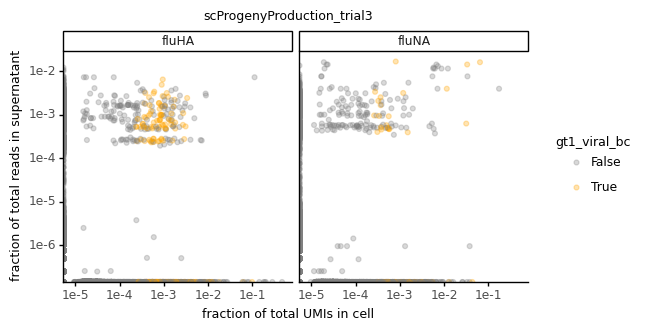

<ggplot: (8746651729071)>

In [29]:
fig = (p9.ggplot(viral_bc_freqs.fillna(0),
                 p9.aes(x='frac_viral_bc_UMIs',
                        y='freq_progeny',
                        color='gt1_viral_bc')) +
       p9.geom_point(alpha=0.3) +
       p9.facet_grid('~gene') +
       p9.ggtitle(f'{expt}') +
       p9.scale_x_log10() +
       p9.scale_y_log10() +
       p9.labs(x='fraction of total UMIs in cell',
               y='fraction of total reads in supernatant') +
       p9.theme(figure_size=(6, 3),
                plot_title=p9.element_text(size=9),
                axis_title=p9.element_text(size=9),
                legend_title=p9.element_text(size=9),
                legend_title_align='center') +
       p9.scale_color_manual(values=['grey','orange']))
display(fig)

### Viral barcode rank in cell
I will rank each viral barcode in each cell-gene. I will see what fraction of all viral barcode UMIs each viral barcode accounts for.

To do this, I will:
* Group viral barcodes by cell-gene
* Sum fraction of cell UMIs that are assigned to any viral barcode in that cell-gene
* Rank only viral barcodes **that are significant above uninfected background**
* Plot rank vs fraction of viral barcode UMIs

Sum all viral bc freqs for each cell-gene:

In [30]:
viral_bc_freqs = (
    viral_bc_freqs
    .assign(
        cell_total_frac_viral_bc_UMIs=lambda x: x
                                                .groupby(['cell_barcode',
                                                          'gene'])
                                                ['frac_viral_bc_UMIs']
                                                .transform('sum')))

viral_bc_freqs

,cell_barcode,infected,infecting_viral_tag,gene,frac_viral_UMIs,viral_barcode,viral_bc_UMIs,frac_viral_bc_UMIs,reject_uninfected,sup_count,freq_progeny,in_infected_cell,n_cell_bc,gt1_cell,n_viral_bc,gt1_viral_bc,cell_total_frac_viral_bc_UMIs
0,AAACCCAGTAACAAGT,False,none,fluHA,0.000048,NaN,0.0,0.0,False,NaN,0.000000e+00,False,NaN,False,NaN,False,0.0
1,AAACCCATCATTGCTT,False,none,fluHA,0.000051,NaN,0.0,0.0,False,NaN,0.000000e+00,False,NaN,False,NaN,False,0.0
2,AAACGAAAGATGTTGA,False,none,fluHA,0.000204,NaN,0.0,0.0,False,NaN,0.000000e+00,False,NaN,False,NaN,False,0.0
3,AAACGCTCAAATGATG,False,none,fluHA,0.000107,NaN,0.0,0.0,False,NaN,0.000000e+00,False,NaN,False,NaN,False,0.0
4,AAACGCTCATGGACAG,False,none,fluHA,0.000119,NaN,0.0,0.0,False,NaN,0.000000e+00,False,NaN,False,NaN,False,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66332,NaN,NaN,wt,fluNA,NaN,TTTTTCCCTTACATAT,NaN,NaN,NaN,1.0,4.799773e-07,False,NaN,False,NaN,False,NaN
66333,NaN,NaN,wt,fluNA,NaN,TTTTTCTTACGATCAC,NaN,NaN,NaN,1.0,4.799773e-07,False,NaN,False,NaN,False,NaN
66334,NaN,NaN,wt,fluNA,NaN,TTTTTCTTCGAGATAG,NaN,NaN,NaN,10.0,4.799773e-06,False,NaN,False,NaN,False,NaN
66335,NaN,NaN,wt,fluNA,NaN,TTTTTGGGATCATTGC,NaN,NaN,NaN,2.0,9.599545e-07,False,NaN,False,NaN,False,NaN


Calculate proportion of viral bc freqs in cell-gene derived from each individual viral bc:

In [31]:
viral_bc_freqs = (
    viral_bc_freqs
    .assign(
        prop_cell_viral_bc_UMIs=lambda x: x['frac_viral_bc_UMIs'] /
                                          x['cell_total_frac_viral_bc_UMIs']))

viral_bc_freqs

,cell_barcode,infected,infecting_viral_tag,gene,frac_viral_UMIs,viral_barcode,viral_bc_UMIs,frac_viral_bc_UMIs,reject_uninfected,sup_count,freq_progeny,in_infected_cell,n_cell_bc,gt1_cell,n_viral_bc,gt1_viral_bc,cell_total_frac_viral_bc_UMIs,prop_cell_viral_bc_UMIs
0,AAACCCAGTAACAAGT,False,none,fluHA,0.000048,NaN,0.0,0.0,False,NaN,0.000000e+00,False,NaN,False,NaN,False,0.0,NaN
1,AAACCCATCATTGCTT,False,none,fluHA,0.000051,NaN,0.0,0.0,False,NaN,0.000000e+00,False,NaN,False,NaN,False,0.0,NaN
2,AAACGAAAGATGTTGA,False,none,fluHA,0.000204,NaN,0.0,0.0,False,NaN,0.000000e+00,False,NaN,False,NaN,False,0.0,NaN
3,AAACGCTCAAATGATG,False,none,fluHA,0.000107,NaN,0.0,0.0,False,NaN,0.000000e+00,False,NaN,False,NaN,False,0.0,NaN
4,AAACGCTCATGGACAG,False,none,fluHA,0.000119,NaN,0.0,0.0,False,NaN,0.000000e+00,False,NaN,False,NaN,False,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66332,NaN,NaN,wt,fluNA,NaN,TTTTTCCCTTACATAT,NaN,NaN,NaN,1.0,4.799773e-07,False,NaN,False,NaN,False,NaN,NaN
66333,NaN,NaN,wt,fluNA,NaN,TTTTTCTTACGATCAC,NaN,NaN,NaN,1.0,4.799773e-07,False,NaN,False,NaN,False,NaN,NaN
66334,NaN,NaN,wt,fluNA,NaN,TTTTTCTTCGAGATAG,NaN,NaN,NaN,10.0,4.799773e-06,False,NaN,False,NaN,False,NaN,NaN
66335,NaN,NaN,wt,fluNA,NaN,TTTTTGGGATCATTGC,NaN,NaN,NaN,2.0,9.599545e-07,False,NaN,False,NaN,False,NaN,NaN


Rank viral barcodes within each cell-gene

In [32]:
viral_bc_freqs = (
    viral_bc_freqs
    .assign(viral_bc_rank=lambda x: x.groupby(['cell_barcode', 'gene'])
                                     ['prop_cell_viral_bc_UMIs']
                                     .rank('dense', ascending=False)))

viral_bc_freqs

,cell_barcode,infected,infecting_viral_tag,gene,frac_viral_UMIs,viral_barcode,viral_bc_UMIs,frac_viral_bc_UMIs,reject_uninfected,sup_count,freq_progeny,in_infected_cell,n_cell_bc,gt1_cell,n_viral_bc,gt1_viral_bc,cell_total_frac_viral_bc_UMIs,prop_cell_viral_bc_UMIs,viral_bc_rank
0,AAACCCAGTAACAAGT,False,none,fluHA,0.000048,NaN,0.0,0.0,False,NaN,0.000000e+00,False,NaN,False,NaN,False,0.0,NaN,NaN
1,AAACCCATCATTGCTT,False,none,fluHA,0.000051,NaN,0.0,0.0,False,NaN,0.000000e+00,False,NaN,False,NaN,False,0.0,NaN,NaN
2,AAACGAAAGATGTTGA,False,none,fluHA,0.000204,NaN,0.0,0.0,False,NaN,0.000000e+00,False,NaN,False,NaN,False,0.0,NaN,NaN
3,AAACGCTCAAATGATG,False,none,fluHA,0.000107,NaN,0.0,0.0,False,NaN,0.000000e+00,False,NaN,False,NaN,False,0.0,NaN,NaN
4,AAACGCTCATGGACAG,False,none,fluHA,0.000119,NaN,0.0,0.0,False,NaN,0.000000e+00,False,NaN,False,NaN,False,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66332,NaN,NaN,wt,fluNA,NaN,TTTTTCCCTTACATAT,NaN,NaN,NaN,1.0,4.799773e-07,False,NaN,False,NaN,False,NaN,NaN,NaN
66333,NaN,NaN,wt,fluNA,NaN,TTTTTCTTACGATCAC,NaN,NaN,NaN,1.0,4.799773e-07,False,NaN,False,NaN,False,NaN,NaN,NaN
66334,NaN,NaN,wt,fluNA,NaN,TTTTTCTTCGAGATAG,NaN,NaN,NaN,10.0,4.799773e-06,False,NaN,False,NaN,False,NaN,NaN,NaN
66335,NaN,NaN,wt,fluNA,NaN,TTTTTGGGATCATTGC,NaN,NaN,NaN,2.0,9.599545e-07,False,NaN,False,NaN,False,NaN,NaN,NaN


Plot distribution of viral barcode ranks. Only look at viral barcodes present in the transcriptome and found above background frequency.

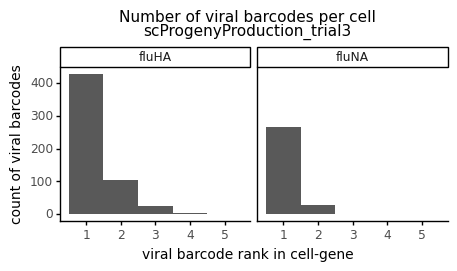

<ggplot: (8746281512039)>

In [33]:
fig = (p9.ggplot(viral_bc_freqs
                 .query('(reject_uninfected == True) and '
                        '(cell_barcode.notna())',
                        engine='python')) +
       p9.geom_histogram(p9.aes(x='viral_bc_rank'),
                         binwidth=1,
                         position='dodge') +
       p9.facet_grid('~gene') +
       p9.ggtitle('Number of viral barcodes per cell\n'
                  f'{expt}') +
       p9.xlab('viral barcode rank in cell-gene') +
       p9.ylab('count of viral barcodes') +
       p9.theme(figure_size=(5, 2),
                plot_title=p9.element_text(size=11),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=10),
                legend_title_align='center'))
display(fig)

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/plotnine/layer.py:467: PlotnineWarning: geom_point : Removed 61998 rows containing missing values.


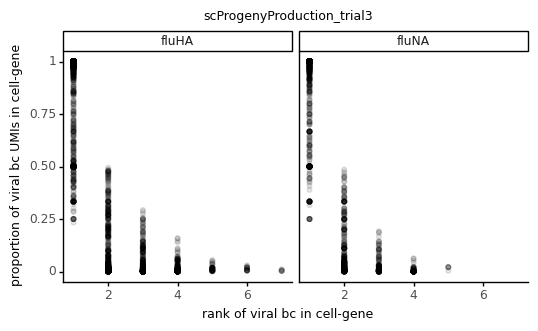

<ggplot: (8746281572256)>

In [34]:
fig = (p9.ggplot((viral_bc_freqs),
                 p9.aes(x='viral_bc_rank',
                        y='prop_cell_viral_bc_UMIs')) +
       p9.geom_point(alpha=0.1) +
       p9.facet_grid('~gene') +
       p9.ggtitle(f'{expt}') +
       p9.labs(x='rank of viral bc in cell-gene',
               y='proportion of viral bc UMIs in cell-gene') +
       p9.theme(figure_size=(6, 3),
                plot_title=p9.element_text(size=9),
                axis_title=p9.element_text(size=9),
                legend_title=p9.element_text(size=9),
                legend_title_align='center') +
      p9.scale_color_discrete(guide=False))
display(fig)

Annotate most abundant viral barcode for each cell-gene:

In [35]:
viral_bc_freqs['top_viral_bc'] = (viral_bc_freqs['viral_bc_rank'] == 1)
viral_bc_freqs['top_viral_bc'].value_counts()

False    64300
True      2037
Name: top_viral_bc, dtype: int64

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10


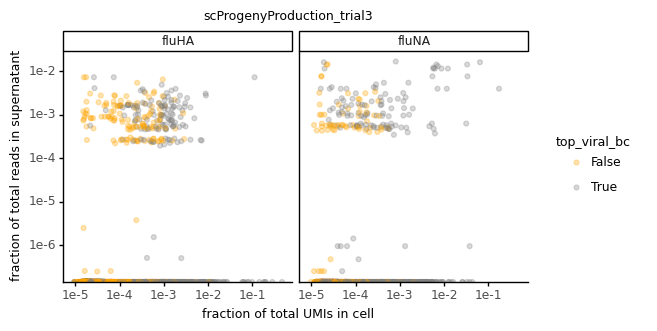

<ggplot: (8745992240866)>

In [36]:
fig = (p9.ggplot(viral_bc_freqs
                 .query('(viral_bc_rank.notna())',
                        engine='python'),
                 p9.aes(x='frac_viral_bc_UMIs',
                        y='freq_progeny',
                        color='top_viral_bc')) +
       p9.geom_point(alpha=0.3) +
       p9.facet_grid('~gene') +
       p9.ggtitle(f'{expt}') +
       p9.scale_x_log10() +
       p9.scale_y_log10() +
       p9.labs(x='fraction of total UMIs in cell',
               y='fraction of total reads in supernatant') +
       p9.theme(figure_size=(6, 3),
                plot_title=p9.element_text(size=9),
                axis_title=p9.element_text(size=9),
                legend_title=p9.element_text(size=9),
                legend_title_align='center') +
       p9.scale_color_manual(values=['orange','grey']))
display(fig)

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/plotnine/guides/guides.py:197: PlotnineWarning: Cannot generate legend for the 'color' aesthetic. Make sure you have mapped a variable to it


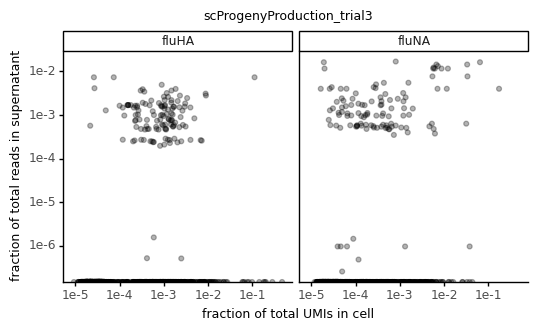

<ggplot: (8745968676979)>

In [37]:
fig = (p9.ggplot(viral_bc_freqs
                 .fillna(0)
                 .query('(top_viral_bc == True)'),
                 p9.aes(x='frac_viral_bc_UMIs',
                        y='freq_progeny')) +
       p9.geom_point(alpha=0.3) +
       p9.facet_grid('~gene') +
       p9.ggtitle(f'{expt}') +
       p9.scale_x_log10() +
       p9.scale_y_log10() +
       p9.labs(x='fraction of total UMIs in cell',
               y='fraction of total reads in supernatant') +
       p9.theme(figure_size=(6, 3),
                plot_title=p9.element_text(size=9),
                axis_title=p9.element_text(size=9),
                legend_title=p9.element_text(size=9),
                legend_title_align='center') +
       p9.scale_color_manual(values=['orange','grey']))
display(fig)

### Viral burden
Plot the viral burden (total fraction of viral UMIs in cell) against the supernatant frequency of the most abundant viral barcode for that cell.

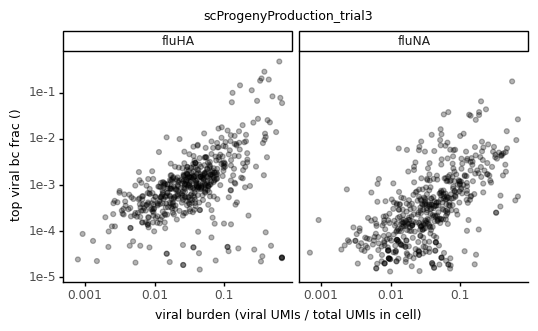

<ggplot: (8745992104509)>

In [38]:
fig = (p9.ggplot(viral_bc_freqs
                 .fillna(0)
                 .query('(infected == True) and'
                        '(top_viral_bc == True)'),
                 p9.aes(x='frac_viral_UMIs',
                        y='frac_viral_bc_UMIs')) +
       p9.geom_point(alpha=0.3) +
       p9.facet_grid('~gene') +
       p9.ggtitle(f'{expt}') +
       p9.scale_x_log10() +
       p9.scale_y_log10() +
       p9.labs(x='viral burden (viral UMIs / total UMIs in cell)',
               y='top viral bc frac ()') +
       p9.theme(figure_size=(6, 3),
                plot_title=p9.element_text(size=9),
                axis_title=p9.element_text(size=9),
                legend_title=p9.element_text(size=9),
                legend_title_align='center'))
display(fig)

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10


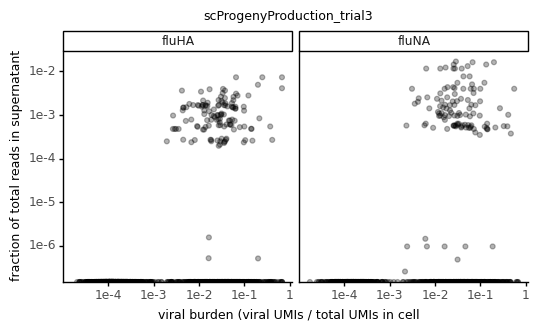

<ggplot: (8745992077972)>

In [39]:
fig = (p9.ggplot(viral_bc_freqs
                 .fillna(0)
                 .query('top_viral_bc == True',
                        engine='python'),
                 p9.aes(x='frac_viral_UMIs',
                        y='freq_progeny')) +
       p9.geom_point(alpha=0.3) +
       p9.facet_grid('~gene') +
       p9.ggtitle(f'{expt}') +
       p9.scale_x_log10() +
       p9.scale_y_log10() +
       p9.labs(x='viral burden (viral UMIs / total UMIs in cell',
               y='fraction of total reads in supernatant') +
       p9.theme(figure_size=(6, 3),
                plot_title=p9.element_text(size=9),
                axis_title=p9.element_text(size=9),
                legend_title=p9.element_text(size=9),
                legend_title_align='center'))
display(fig)

## Gene analysis
Start by loading cell-gene matrix into an [AnnData](https://anndata.readthedocs.io/) object:

In [40]:
adata = scanpy.read_mtx(matrix)
adata.var = pd.read_csv(cell_barcodes,
                        names=['cell_barcode'])
adata.obs = pd.read_csv(features,
                        sep='\t',
                        names=['ensemble_id', 'gene', 'feature_type'])

print(f"Read cell-gene matrix of {adata.n_vars} cells and {adata.n_obs} genes")

assert set(viral_genes).issubset(set(adata.obs['gene'])), 'lack viral genes'

Read cell-gene matrix of 3368 cells and 30959 genes


Annotate cell barcodes by infecting tag:

In [41]:
adata.var = (pd.merge(
                left=adata.var,
                right=all_cells,
                on=['cell_barcode'],
                how='left')
            .reset_index(drop=True)) #Reset index to maintain RangeIndex data type

adata.var

,cell_barcode,infected,infecting_viral_tag
0,AAACCCAGTAACAAGT,False,none
1,AAACCCATCATTGCTT,False,none
2,AAACGAAAGATGTTGA,False,none
3,AAACGAAGTACTTCCC,True,both
4,AAACGAAGTAGACGTG,True,wt
...,...,...,...
3363,TTTGATCTCCCGTTCA,False,none
3364,TTTGATCTCGCATTGA,True,wt
3365,TTTGGAGAGTTGCCTA,False,none
3366,TTTGGAGGTATCGTTG,True,wt


Get total and viral UMI counts for each cell:

In [42]:
umi_counts = (
    adata.var
    .assign(total_UMIs=numpy.sum(adata.X, axis=0).A1.astype(int),
            viral_UMIs=numpy.sum(adata[adata.obs['gene']
                                       .isin(viral_genes), ].X,
                                 axis=0).A1.astype(int),
            frac_viral_UMIs=lambda x: x['viral_UMIs'] / x['total_UMIs']
            )
    )

umi_counts

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


,cell_barcode,infected,infecting_viral_tag,total_UMIs,viral_UMIs,frac_viral_UMIs
0,AAACCCAGTAACAAGT,False,none,20969,1,0.000048
1,AAACCCATCATTGCTT,False,none,39505,2,0.000051
2,AAACGAAAGATGTTGA,False,none,49137,10,0.000204
3,AAACGAAGTACTTCCC,True,both,25547,11452,0.448272
4,AAACGAAGTAGACGTG,True,wt,53719,2155,0.040116
...,...,...,...,...,...,...
3363,TTTGATCTCCCGTTCA,False,none,27511,3,0.000109
3364,TTTGATCTCGCATTGA,True,wt,73596,4648,0.063156
3365,TTTGGAGAGTTGCCTA,False,none,28413,2,0.000070
3366,TTTGGAGGTATCGTTG,True,wt,65134,1598,0.024534


### Viral gene expression
Get the UMI counts for each viral gene in each cell:

In [43]:
viral_gene_expression = umi_counts
viral_gene_expression = (
    viral_gene_expression
    .assign(fluPB2_UMIs=(numpy.sum(adata[adata.obs['gene'] == 'fluPB2', ].X,
                                     axis=0).A1.astype(int)),
            fluPB1_UMIs=(numpy.sum(adata[adata.obs['gene'] == 'fluPB1', ].X,
                                     axis=0).A1.astype(int)),
            fluPA_UMIs=(numpy.sum(adata[adata.obs['gene'] == 'fluPA', ].X,
                                    axis=0).A1.astype(int)),
            fluHA_UMIs=(numpy.sum(adata[adata.obs['gene'] == 'fluHA', ].X,
                                    axis=0).A1.astype(int)),
            fluNP_UMIs=(numpy.sum(adata[adata.obs['gene'] == 'fluNP', ].X,
                                    axis=0).A1.astype(int)),
            fluNA_UMIs=(numpy.sum(adata[adata.obs['gene'] == 'fluNA', ].X,
                                    axis=0).A1.astype(int)),
            fluM_UMIs=(numpy.sum(adata[adata.obs['gene'] == 'fluM', ].X,
                                    axis=0).A1.astype(int)),
            fluNS_UMIs=(numpy.sum(adata[adata.obs['gene'] == 'fluNS', ].X,
                                    axis=0).A1.astype(int)),
           )
)

viral_gene_expression

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


,cell_barcode,infected,infecting_viral_tag,total_UMIs,viral_UMIs,frac_viral_UMIs,fluPB2_UMIs,fluPB1_UMIs,fluPA_UMIs,fluHA_UMIs,fluNP_UMIs,fluNA_UMIs,fluM_UMIs,fluNS_UMIs
0,AAACCCAGTAACAAGT,False,none,20969,1,0.000048,0,0,0,0,0,0,1,0
1,AAACCCATCATTGCTT,False,none,39505,2,0.000051,1,0,0,1,0,0,0,0
2,AAACGAAAGATGTTGA,False,none,49137,10,0.000204,0,0,0,0,0,0,6,4
3,AAACGAAGTACTTCCC,True,both,25547,11452,0.448272,78,232,8,1,1780,192,6276,2885
4,AAACGAAGTAGACGTG,True,wt,53719,2155,0.040116,2,17,4,142,286,13,708,983
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3363,TTTGATCTCCCGTTCA,False,none,27511,3,0.000109,0,0,0,0,1,0,1,1
3364,TTTGATCTCGCATTGA,True,wt,73596,4648,0.063156,13,46,3,257,526,496,2251,1056
3365,TTTGGAGAGTTGCCTA,False,none,28413,2,0.000070,0,0,0,0,1,0,1,0
3366,TTTGGAGGTATCGTTG,True,wt,65134,1598,0.024534,5,29,2,39,188,17,750,568


Pivot the table so that gene is in a column and UMI/frac are their own columns:

In [57]:
viral_gene_expression_long = viral_gene_expression.melt(
    id_vars=['cell_barcode',
             'infected',
             'infecting_viral_tag',
             'total_UMIs',
             'viral_UMIs',
             'frac_viral_UMIs'],
    var_name='gene',
    value_name='gene_UMIs'
)

#viral_gene_expression['gene'] = viral_gene_expression['gene'].strip('_UMIs')
viral_gene_expression_long

,cell_barcode,infected,infecting_viral_tag,total_UMIs,viral_UMIs,frac_viral_UMIs,gene,gene_UMIs
0,AAACCCAGTAACAAGT,False,none,20969,1,0.000048,fluPB2_UMIs,0
1,AAACCCATCATTGCTT,False,none,39505,2,0.000051,fluPB2_UMIs,1
2,AAACGAAAGATGTTGA,False,none,49137,10,0.000204,fluPB2_UMIs,0
3,AAACGAAGTACTTCCC,True,both,25547,11452,0.448272,fluPB2_UMIs,78
4,AAACGAAGTAGACGTG,True,wt,53719,2155,0.040116,fluPB2_UMIs,2
...,...,...,...,...,...,...,...,...
26939,TTTGATCTCCCGTTCA,False,none,27511,3,0.000109,fluNS_UMIs,1
26940,TTTGATCTCGCATTGA,True,wt,73596,4648,0.063156,fluNS_UMIs,1056
26941,TTTGGAGAGTTGCCTA,False,none,28413,2,0.000070,fluNS_UMIs,0
26942,TTTGGAGGTATCGTTG,True,wt,65134,1598,0.024534,fluNS_UMIs,568


Calculate fraction of UMIs assigned to each viral gene:

In [58]:
viral_gene_expression_long['frac_UMIs'] = (viral_gene_expression_long['gene_UMIs'] /
                                           viral_gene_expression_long['total_UMIs']
                                          )

viral_gene_expression_long

,cell_barcode,infected,infecting_viral_tag,total_UMIs,viral_UMIs,frac_viral_UMIs,gene,gene_UMIs,frac_UMIs
0,AAACCCAGTAACAAGT,False,none,20969,1,0.000048,fluPB2_UMIs,0,0.000000
1,AAACCCATCATTGCTT,False,none,39505,2,0.000051,fluPB2_UMIs,1,0.000025
2,AAACGAAAGATGTTGA,False,none,49137,10,0.000204,fluPB2_UMIs,0,0.000000
3,AAACGAAGTACTTCCC,True,both,25547,11452,0.448272,fluPB2_UMIs,78,0.003053
4,AAACGAAGTAGACGTG,True,wt,53719,2155,0.040116,fluPB2_UMIs,2,0.000037
...,...,...,...,...,...,...,...,...,...
26939,TTTGATCTCCCGTTCA,False,none,27511,3,0.000109,fluNS_UMIs,1,0.000036
26940,TTTGATCTCGCATTGA,True,wt,73596,4648,0.063156,fluNS_UMIs,1056,0.014349
26941,TTTGGAGAGTTGCCTA,False,none,28413,2,0.000070,fluNS_UMIs,0,0.000000
26942,TTTGGAGGTATCGTTG,True,wt,65134,1598,0.024534,fluNS_UMIs,568,0.008720
